<a href="https://colab.research.google.com/github/Abdel-Moussaoui/Auto-Encoders/blob/master/simple_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 0.3651 - val_loss: 0.2723
Epoch 2/100
 - 2s - loss: 0.2641 - val_loss: 0.2524
Epoch 3/100
 - 2s - loss: 0.2422 - val_loss: 0.2301
Epoch 4/100
 - 2s - loss: 0.2227 - val_loss: 0.2132
Epoch 5/100
 - 2s - loss: 0.2085 - val_loss: 0.2012
Epoch 6/100
 - 2s - loss: 0.1980 - val_loss: 0.1921
Epoch 7/100
 - 2s - loss: 0.1898 - val_loss: 0.1849
Epoch 8/100
 - 2s - loss: 0.1831 - val_loss: 0.1787
Epoch 9/100
 - 2s - loss: 0.1774 - val_loss: 0.1735
Epoch 10/100
 - 2s - loss: 0.1724 - val_loss: 0.1689
Epoch 11/100
 - 2s - loss: 0.1678 - val_loss: 0.1644
Epoch 12/100
 - 2s - loss: 0.1637 - val_loss: 0.1604
Epoch 13/100
 - 2s - loss: 0.1598 - val_loss: 0.1566
Epoch 14/100
 - 2s - loss: 0.1563 - val_loss: 0.1532
Epoch 15/100
 - 2s - loss: 0.1530 - val_loss: 0.1500
Epoch 16/100
 - 2s - loss: 0.1499 - val_loss: 0.1472
Epoch 17/100
 - 2s -

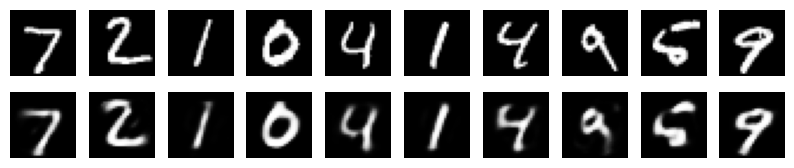

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Single fully-connected neural layer as encoder and decoder

use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(10e-8)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

# this is the size of our encoded representations
encoding_dim = 32   # 32 floats -> compression factor 24.5, assuming the input is 784 floats

# this is our input placeholder; 784 = 28 x 28
input_img = Input(shape=(784, ))

# "encoded" is the encoded representation of the inputs
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# Separate Encoder model

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# Separate Decoder model

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Train to reconstruct MNIST digits

# configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# prepare input data
(x_train, _), (x_test, y_test) = mnist.load_data()

# normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# Train autoencoder for 50 epochs

autoencoder.fit(x_train, x_train, epochs=my_epochs, batch_size=256, shuffle=True, validation_data=(x_test, x_test),
                verbose=2)

# after 50/100 epochs the autoencoder seems to reach a stable train/test lost value

# Visualize the reconstructed encoded representations

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# save latent space features 32-d vector
pickle.dump(encoded_imgs, open(features_path, 'wb'))
pickle.dump(y_test, open(labels_path, 'wb'))

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

K.clear_session()
